# Bernoulli Verification Example - Mesh Convergence Study

In [1]:
# units in kN, cm
L, d, t = 100.0, 5., 2.
Ex, nu = 21000.0, 0.25
q = 1.0

## Linear Solution

In [2]:
from sigmaepsilon import Structure, LineMesh, PointData, BeamSection
from sigmaepsilon.fem.cells import B2, B3
from polymesh.space import StandardFrame, PointCloud
from polymesh.utils.space import index_of_closest_point
from polymesh.utils.topology import L2_to_L3
from linkeddeepdict.tools import getallfromkwargs
from neumann.linalg import linspace
from neumann import repeat
import numpy as np

iN = None  # index of the node at the free end

# section
section = BeamSection('CHS', d=d, t=t, n=16)
section.calculate_section_properties()
section_props = section.section_properties
A, Ix, Iy, Iz = getallfromkwargs(['A', 'Ix', 'Iy', 'Iz'], **section_props)

# material
G = Ex / (2 * (1 + nu))
Hooke = np.array([
    [Ex*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, Ex*Iy, 0],
    [0, 0, 0, Ex*Iz]
])


def build_structure(n: int, celltype=B3):
    global iN

    # space
    GlobalFrame = StandardFrame(dim=3)

    # mesh
    p0 = np.array([0., 0., 0.])
    p1 = np.array([L, 0., 0.])
    coords = linspace(p0, p1, n+1)
    coords = PointCloud(coords, frame=GlobalFrame).show()
    topo = np.zeros((n, 2), dtype=int)
    topo[:, 0] = np.arange(n)
    topo[:, 1] = np.arange(n) + 1

    if celltype.NNODE == 3:
        coords, topo = L2_to_L3(coords, topo)
    iN = index_of_closest_point(coords, np.array([L, 0, 0]))

    # essential boundary conditions
    ebcinds = np.where(coords[:, 0] < 1e-12)[0]
    fixity = np.zeros((coords.shape[0], 6)).astype(bool)
    fixity[ebcinds, :] = True

    # natural boundary conditions
    nodal_loads = np.zeros((coords.shape[0], 6))
    cell_loads = np.zeros((topo.shape[0], topo.shape[1], 6))
    cell_loads[:, :, :] = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

    # pointdata
    pd = PointData(coords=coords, fixity=fixity, loads=nodal_loads,
                   frame=GlobalFrame)

    # celldata
    frames = repeat(GlobalFrame.show(), topo.shape[0])
    cd = celltype(topo=topo, loads=cell_loads, material=Hooke, frames=frames)

    # set up mesh and structure
    mesh = LineMesh(pd, cd, frame=GlobalFrame)
    structure = Structure(mesh=mesh)
    return structure


def calc_dofsol(n: int = 2, *, structure=None):
    if structure is None:
        structure = build_structure(n)
        structure.linsolve()
    return structure.nodal_dof_solution(store='dofsol')


def calc_dofsol_at_free_end(n: int = 2, *, structure=None):
    if structure is None:
        structure = build_structure(n)
        structure.linsolve()
        d = structure.nodal_dof_solution(store='dofsol')
    else:
        d = calc_dofsol(structure=structure)
    return d[iN]


def calc_reaction_forces(n: int = 2, *, structure=None):
    if structure is None:
        structure = build_structure(n)
        structure.linsolve()
        structure.nodal_dof_solution(store='dofsol')
    r = structure.reaction_forces()
    return r[0]


def calc_internal_forces(n: int = 2, *, structure=None):
    if structure is None:
        structure = build_structure(n)
        structure.linsolve()
        structure.nodal_dof_solution(store='dofsol')
    r = structure.internal_forces()
    return r[0]

def calc_external_forces(n: int = 2, *, structure=None):
    if structure is None:
        structure = build_structure(n)
        structure.linsolve()
        structure.nodal_dof_solution(store='dofsol')
    r = structure.external_forces()
    return r[0]


In [3]:
calc_dofsol_at_free_end(2)


array([ 0.        , 20.70417285,  0.        ,  0.        ,  0.        ,
        0.27767949])

In [4]:
calc_reaction_forces(2)


array([    0.,  -100.,     0.,     0.,     0., -5000.])

In [5]:
calc_internal_forces(2)


array([[[   0.        ],
        [  92.85714286],
        [   0.        ],
        [   0.        ],
        [   0.        ],
        [4970.23809524]],

       [[   0.        ],
        [  75.        ],
        [   0.        ],
        [   0.        ],
        [   0.        ],
        [2872.02380952]],

       [[   0.        ],
        [  57.14285714],
        [   0.        ],
        [   0.        ],
        [   0.        ],
        [1220.23809524]]])

In [6]:
calc_external_forces(2)

array([[[ 0.00000000e+00],
        [-8.45238095e+01],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [-4.94047619e+03]],

       [[ 0.00000000e+00],
        [ 1.90476190e+01],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [-3.63797881e-12]],

       [[ 0.00000000e+00],
        [ 6.54761905e+01],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 1.19047619e+03]]])

## Analytic Solution

In [7]:
UY_exact = q * L**4 / (8 * Ex * Iy)
RY_exact = - q * L
FY_exact = - RY_exact

## Mesh Convergence

In [8]:
ns = [2, 4, 10, 20, 40, 60, 80, 100]
#ns = [2, 4, 10]

In [9]:
uyB2, ryB2, fyB2 = [], [], []
for n in ns:
    s = build_structure(n, B2)
    s.linsolve()
    u_n = calc_dofsol_at_free_end(structure=s)
    r_n = calc_reaction_forces(structure=s)
    f_n = calc_internal_forces(structure=s)
    uyB2.append(u_n[1] / UY_exact)
    ryB2.append(r_n[1] / RY_exact)
    fyB2.append(f_n[0, 1] / FY_exact)
    
uyB3, ryB3, fyB3 = [], [], []
for n in ns:
    s = build_structure(n, B3)
    s.linsolve()
    u_n = calc_dofsol_at_free_end(structure=s)
    r_n = calc_reaction_forces(structure=s)
    f_n = calc_internal_forces(structure=s)
    uyB3.append(u_n[1] / UY_exact)
    ryB3.append(r_n[1] / RY_exact)
    fyB3.append(f_n[0, 1] / FY_exact)
    

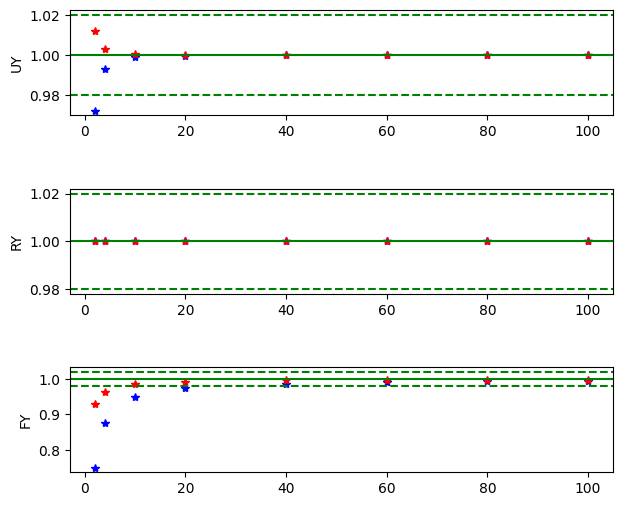

In [10]:
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 6))  # in inches
gs = gridspec.GridSpec(3, 1, hspace=0.7, wspace=0.5)
axes = []

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('UY')
ax1.plot(ns, uyB2, 'b*')
ax1.plot(ns, uyB3, 'r*')

ax2 = fig.add_subplot(gs[1, 0])
ax2.set_ylabel('RY')
ax2.plot(ns, ryB2, 'b*')
ax2.plot(ns, ryB3, 'r*')

ax3 = fig.add_subplot(gs[2, 0])
ax3.set_ylabel('FY')
ax3.plot(ns, fyB2, 'b*')
ax3.plot(ns, fyB3, 'r*')

axes.append(ax1)
axes.append(ax2)
axes.append(ax3)

for ax in axes:
    ax.axhline(y=1.02, color='g', linestyle='--')
    ax.axhline(y=1, color='g', linestyle='-')
    ax.axhline(y=0.98, color='g', linestyle='--')
    #ax.set_ylim([0.95, 1.05])